# R code for the project

In [10]:
#proof that line 67 in the cell below is overwritten by the for loop
#it's useless to impose the last element of empSAR 
#it has to be the estimation and not the true value
Tot_plot <- 5
Tot_species <-7

empSAR<-rep(0,Tot_plot)     #repeat 0, Tot_plot times
empSAR[1]<-0    #primo elem di empSAR è la media delle specie presenti in 1 cella (row)
empSAR[length(empSAR)]<-Tot_species    
empSAR[length(empSAR)]
empSAR

for (i in 2:Tot_plot){
     empSAR[i]<-1
}

empSAR

[1] 7

[1] 0 0 0 0 7

[1] 0 1 1 1 1

In [1]:
############################################################################################################
##############     Inferring macro-ecological patterns from local species’ occurrences     #################
############################################################################################################
# 
# INPUT:  initial_data -> MxS matrix where M is the number of spatial cells into
#                         which the plot is divided and S is the number of species
#                         data[i,j] is 1 if species j is found in cell i, 0 otherwise
#         area -> area of the plot to which we wish to upscale
#         sampled_area -> total area of the surveyed samples
#         estimated_r -> optional estimation of r (options: a positive real number or "try you")
#         estimated_csi -> optional estimation of csi (options: a positive real number or "try you")


UpscalingPA<-function(initial_data,area,sampled_area,estimated_r,estimated_csi)
{ print("***********************************************************************",quote=FALSE)
  print("* Inferring macro-ecological patterns from local species’ occurrences *",quote=FALSE)
  print("***********************************************************************",quote=FALSE)
  
  ###########################################################  
  ###############     Check initial input     ###############
  ###########################################################
  
  if(area<sampled_area)
    cat("sampled_area must be smaller than area")
  if(estimated_r<0||estimated_csi<0||estimated_csi>1)
    stop("Estimated parameters for RSA must be in the range r>0 and 0<xi<1")
  if(estimated_r!="try you" & is.numeric(estimated_r)==FALSE)
    stop("Invalid option for estimated_r. It must be either a positive real number or the string 'try you'")
  if(estimated_csi!="try you" & is.numeric(estimated_csi)==FALSE)
    stop("Invalid option for estimated_rho. It must be either a positive real number between 0 and 1 or the string 'try you'")

  ###########################################################
  ###############    Print of Initial Data    ###############
  ###########################################################
  
  # Total number of spatial cells
  cat("***********************************************************\n")
  cat("************           INITIAL DATA:           ************\n")
  cat("***********************************************************\n")
  Tot_plot<-nrow(initial_data)  #to return the number of rows of the specified matrix
  cat(c("Total number of subplots:",Tot_plot))
  cat(" \n")
  
  # Total number of species 
  Tot_species<-length(which(colSums(initial_data)!=0))
  
  cat(c("Total number of found species:",Tot_species))
  cat(" \n")
  

  cat("***********************************************************\n")
  cat("************   COMPUTING THE EMPIRICAL SAR...  ************\n")
  cat("***********************************************************\n")
  

  cat("Percentage of computed distances:\n")
  
  ###########################################################
  ###############        Empirical SAR        ###############
  ###########################################################
  

    empSAR<-rep(0,Tot_plot)     #repeat 0, Tot_plot times
    sdSAR<-rep(0,Tot_plot)      #repeat 0, Tot_plot times
  
    empSAR[1]<-mean(rowSums(initial_data))      #primo elem di empSAR è la media delle specie presenti in 1 cella (row)
    empSAR[length(empSAR)]<-Tot_species         #l'ultimo elemento è il num totale delle specie
                                                #inutile perchè poi viene sovrascritto con il valore stimato!!!
    
    per<-round(Tot_plot*seq(0.1,1,0.1))
    count<-1
    
    for (i in 2:Tot_plot)                       #i è l'indice relativo a quante celle samplare-> relativo a p
      {sar<-rep(0,100)                          #sar è array vuoto da 100 posti (ognuno è un trial diverso)
      for (j in 1:100)                          #j è l'indice del trial
        {Sample<-sample(1:Tot_plot,i)           #estrai i indici da 1 a tot_plot
         sample_matrix<-initial_data[Sample,]   #crea submatrice da matrice iniziale con solo le celle estratte
         presentSpecies<-colSums(sample_matrix) #somma colonne
         sar[j]<-length(presentSpecies[presentSpecies!=0]) #colonne con somma!=0 (=specie presente)
      }                                                    #vengono contate e inserite in sar[j]
      
      empSAR[i]<-sum(sar)/100                   #empirical sar = media sar dei 100 trials
      sdSAR[i]<-sd(sar)
        
      if(i==per[count])                         #stampa la percentuale di calcolo
      {cat(count, "0% ",sep="")
        count<-count+1
      }                 
    }
    
    cat("\n")
    
    x<-1:Tot_plot
    x<-x/Tot_plot
  
  ###########################################################
  ###############       Theoretical SAR       ###############
  ###########################################################
  
  csi.p<- function(samplep,csi) {
    samplep*csi/(1-csi*(1-samplep))
  }
    
  SAR_theo <- function(samplep,r,csi,S) {
    S*(1-(1-csi.p(samplep,csi))^r)/(1-(1-csi)^r)
  }
  
  ###########################################################
  ###############        Fit of the SAR       ###############
  ###########################################################
  if (estimated_r=="try you")
  {estimated_r<-0.2}
  if (estimated_csi=="try you")
  {estimated_csi<-0.999}
  
  # Points to fit
  y<-empSAR
  
  # Fitting model
  options(warn=-1)
  fitSAR<-tryCatch(nls(y~SAR_theo(x,r,csi,Tot_species),data=data.frame(x,y),start=list(r=estimated_r,csi=estimated_csi)),error = function(e) {})
  if(is.null(fitSAR)) 
  {s<-seq(from=0, to=Tot_plot)
  plot(x,y,main="Empirical SAR",xlab="p",ylab="SAR(p)",pch=20,mgp=c(1.8,0.5,0),xlim=c(0,max(x)))
  stop("SAR fitting failed. Try with different rho and lambda initial estimates")}
  options(warn=0)
  cat(" \n")
  
  cat("***********************************************************\n")
  cat("************          FITTING RESULTS:         ************\n")
  cat("***********************************************************\n")
  print(summary(fitSAR))
  
  # Graph of the fitting pcf curve
  par(mar=c(5.1, 4.1, 4.1, 8.1), xpd=TRUE)
  s<-seq(0.01,1,0.01)
  plot(x,y,main="Species Area Relationship",xlab="p",ylab="SAR(p)",pch=20,mgp=c(1.8,0.5,0),ylim=c(0,max(y[1],predict(fitSAR,list(x=1)))))
  lines(s, predict(fitSAR,list(x=s)),col="green",lwd=3)
  legend("topright",inset=c(-0.3,0.3),legend=c("emp","fit"),lwd=c(NA,3),pch=c(20,NA),lty=c(NA,1),col=c("black","green"),pt.cex=1.5,seg.len=1)
  
  r.fit<-as.numeric(abs(coef(fitSAR)[1]))
  csi.fit<-as.numeric(coef(fitSAR)[2])
#fino qui tutto uguale
 
  options(warn=-1)
  std.error.r<-coef(summary(fitSAR))[3]
  std.error.csi<-coef(summary(fitSAR))[4]
  options(warn=0)
  
#qui si decide la frazione per fare upscaling
  p<-sampled_area/area
    
  csi.global<-csi.fit/(p+csi.fit*(1-p))  #formula n4 per passare da csi_star (quello del fit) ad uno csi_global=csi
  S.estimate<-Tot_species*(1-(1-csi.global)^r.fit)/(1-(1-csi.fit)^r.fit) #formula n8
  
  # Computing the error on S.estimate
  upscaling<-expression( Tot_species*(1-(1-csi.fit/(p+csi.fit*(1-p)))^r.fit)/(1-(1-csi.fit)^r.fit) )
  
  der.r<-deriv(upscaling,"r.p")
  der.csi<-deriv(upscaling,"csi.p")
  
  std.error.S<-sqrt(as.numeric(eval(der.csi))^2*std.error.csi^2+as.numeric(eval(der.r))^2*std.error.r^2)
  
  print("***********************************************************",quote=FALSE)
  print(" ",quote=FALSE)
  print("UPSCALING RESULTS:",quote=FALSE)
  print(" ",quote=FALSE)
  print(c("Estimated total biodiversity S:",round(S.estimate)),quote=FALSE)
  print(c("Error on S:",round(std.error.S)),quote=FALSE)
  print(" ",quote=FALSE)
  print("***********************************************************",quote=FALSE)
 
  return(empSAR)
 }


[1] ***********************************************************************
[1] * Inferring macro-ecological patterns from local species’ occurrences *
[1] ***********************************************************************
***********************************************************
************           INITIAL DATA:           ************
***********************************************************
Total number of subplots: 480 
Total number of found species: 4761 
***********************************************************
************   COMPUTING THE EMPIRICAL SAR...  ************
***********************************************************
Percentage of computed distances:
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
 
***********************************************************
************          FITTING RESULTS:         ************
***********************************************************

Formula: y ~ SAR_theo(x, r, csi, Tot_species)

Parameters:
     Estimate Std. Error t

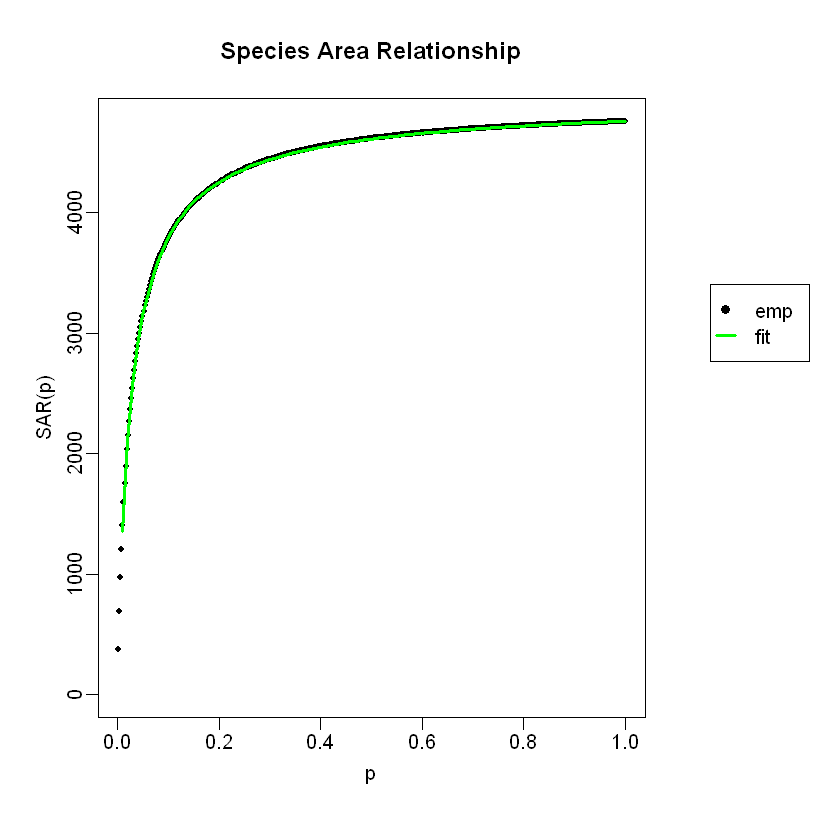

In [2]:
prova <- read.csv('NBpa5_file.csv')
initial_data <- prova
area <- 100
sampled_area <- 5
estimated_r <- 0.2
estimated_csi <- 0.999

#NB 5%
dataNB5 <- UpscalingPA(initial_data,area,sampled_area,estimated_r,estimated_csi)

[1] ***********************************************************************
[1] * Inferring macro-ecological patterns from local species’ occurrences *
[1] ***********************************************************************
***********************************************************
************           INITIAL DATA:           ************
***********************************************************
Total number of subplots: 480 
Total number of found species: 4806 
***********************************************************
************   COMPUTING THE EMPIRICAL SAR...  ************
***********************************************************
Percentage of computed distances:
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
 
***********************************************************
************          FITTING RESULTS:         ************
***********************************************************

Formula: y ~ SAR_theo(x, r, csi, Tot_species)

Parameters:
     Estimate Std. Error t

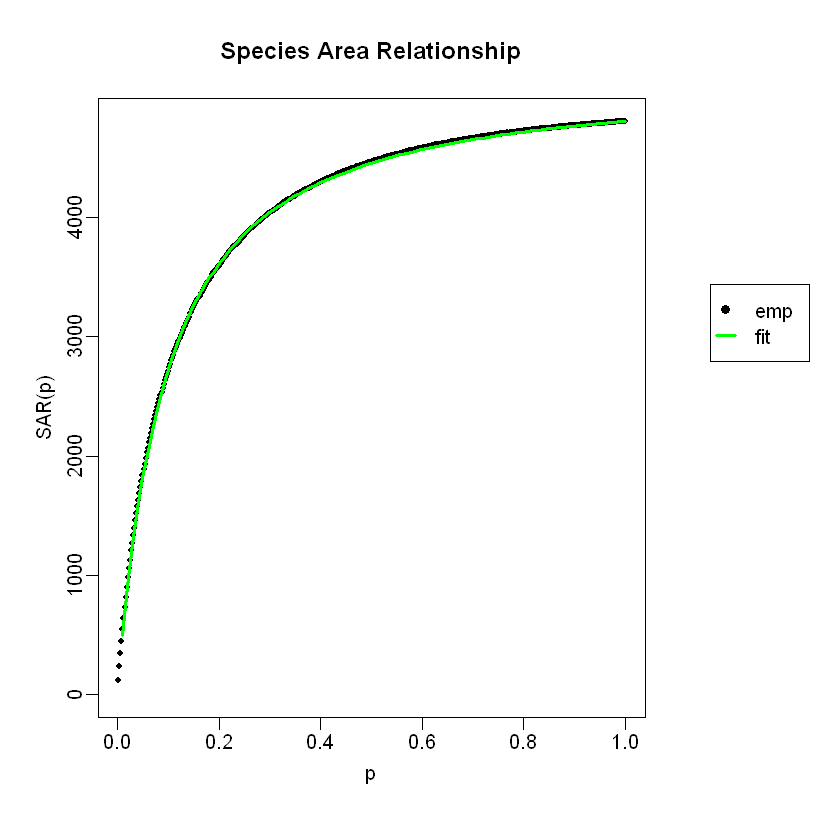

In [5]:
prova1 <- read.csv('LNpa5_file.csv')
initial_data <- prova1
area <- 100
sampled_area <- 5
estimated_r <- 0.2
estimated_csi <- 0.999
#LN 5%
dataLN5 <- UpscalingPA(initial_data,area,sampled_area,estimated_r,estimated_csi)